In [65]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [66]:
# Getting the ticker of the stock that the user wants to work with. 
ticker = input("Please enter the ticker that you want to analyse: ")

In [67]:
# Getting the ticker stock price
stock = yf.Ticker(ticker.upper())
# Querying all the data from a very long time ago. 
stock_history = stock.history(period='20y')
# Taking a closer look at the close price over the past year.
one_year_stock = stock.history(period="1y")
# Getting the names of all the columns in the dataframe that contains the historical data of our stock.
column_names = stock_history.columns

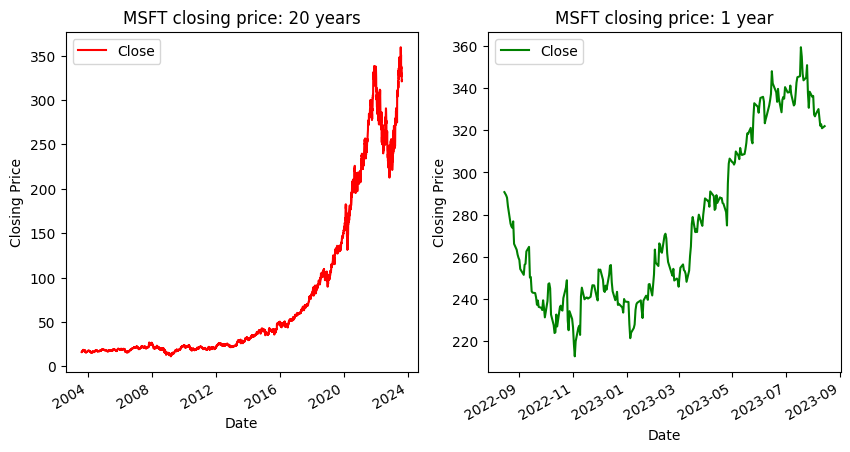

In [68]:
# Creating a subplot
plt.ion()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# Plotting the closing price against the index of the table.
stock_history.plot.line(y="Close", use_index=True, color='red', ax=axes[0])
axes[0].set_title('{} closing price: 20 years'.format(ticker.upper()))
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price')
# Plotting the closing price over the past year against the index of the table.
plot2 = one_year_stock.plot.line(y="Close", use_index=True, color='green', ax=axes[1])
axes[1].set_title('{} closing price: 1 year'.format(ticker.upper()))
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Closing Price')
plt.show()
fig.savefig("./plots/closing_price.jpeg")


In [69]:
# Removing the dividends and the stock splits columns
stock_history = stock_history.drop(['Dividends','Stock Splits'], axis=1)
# We assume that the stock price at the open of a day is the same as that at the close of the previous day.
stock_history['Tomorrow'] = stock_history["Close"].shift(-1)
# Making the target variable which tells us whether the stock price will go up or down tomorrow.
stock_history['Target'] = (stock_history['Tomorrow'] > stock_history['Close']).astype(int)

In [70]:
####################################################
## SPLITTING THE DATA INTO TRAINING AND TEST DATA ##
####################################################
# Since this is time series data, it makes no sense to use the train_test_split function.
training_data = stock_history[:3000]
test_data = stock_history[3000:]
# Creating a list of the columns that we want to use to train our data.
predictor_columns = ['Close', 'Volume', 'Open', 'High', 'Low']
# Turning the training data into numpy arrays. 
x_training_data_array = np.array(training_data[predictor_columns])
y_training_data_array = np.array(training_data['Target'])
# Preparing our testing data
x_test_data_array = np.array(test_data[predictor_columns])
y_test_data_array = np.array(test_data['Target'])

In [72]:
####################################
## BUILDING A RANDOM FOREST MODEL ##
####################################
"""Random Forest Classifier Model
    n_estimators is the number of decision trees we want to use during training. Higher this number, the better it is.
    min_samples_fit helps protect against overfit. The higher this value, the less accurate the model, but the less overfit it will be as well. 
    random_state sets the number of random seeds used to reandomize the forest parmeters. """
random_forest_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
# Fitting the model based on the training data.
random_forest_model.fit(x_training_data_array, y_training_data_array)
# Generating predictions for the test data. We get these predictions in a numpy array. 
predictions = random_forest_model.predict(x_test_data_array)
# Calculating the precision score using the actual target and the predicted target.
calculated_precision_score = precision_score(y_test_data_array, predictions)
print(calculated_precision_score)

0.5517241379310345


In [73]:
#################################################################################
## NOW BUILDING A BACKTESTING SYSTEM THAT IS MORE ACCURATE THAN A NORMAL MODEL ##
#################################################################################

# Creating a prediction function
def prediction_function(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    predictions = pd.Series(predictions, index = test.index, name='Predictions')
    combined_target = pd.concat([test, predictions], axis=1)
    return combined_target

# Creating a backtesting function
"""The Start and Step values help divide up the data into the trianing and prediction data. 
    Such that we are going to take every 2500 days of data, use that to train the model, and predict the outcomes for the nest 250 days.
    This helps get alot more confidence in the model"""

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = prediction_function(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Doing to the actual back testing running the system created above.
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
predictions = backtest(stock_history, random_forest_model, predictors)
# Finding out the number of days we predict the market to go up, and the number of days for it to go down. 
predictions['Predictions'].value_counts()
# Getting the precision score 
precision_score = precision_score(predictions['Target'], predictions['Predictions'])
print(precision_score)
# To calculate the percent of days that the index value went up and went down
predictions['Predictions'].value_counts() / predictions.shape[0]

0.5323671497584541


Predictions
0    0.591555
1    0.408445
Name: count, dtype: float64